## Part 2:

### Sub-genres
So far we have investigated how each rock artist is connected to each other through references on their wiki page. Each of these rock artists are associated with sub-genres based on the info box on their wiki page. Artists who shares a sub-genre likely have the same inspirations, or maybe they have colloborations. Therefore, a hypothesis can be made here, that artists that are characterized by the same sub-genre is more likely to be linked together compared to other artists.

### Testing the hypothesis with modularity

One way to test this hypothesis could be to use modularity. If we consider each collection of artists within a certain sub-genre as a community, then high modularity would indicate a strong community structure. This would suggest that artists are more densely connected within their sub-genres than between different sub-genres, supporting our hypothesis.


## Detecting the communities and calculating the mdoularity

In [18]:
import pickle
import requests
import networkx as nx
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


url = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/answers/rock_artists_network.pkl'
response = requests.get(url)

G_rock = pickle.loads(response.content)

url2 = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%202/artist_genres_without_rock.json'
response2 = requests.get(url2)
artist_genres = response2.json()

"""
Create a new network with only nodes that have genres,
and assign primary genre as node attribute
"""
# Create new graph with same type as original

G_rock = G_rock.to_undirected()

G_filtered = nx.Graph()

# Map nodes to their primary genre
node_to_primary_genre = {}

for node in G_rock.nodes():
    # Check if node has genres (handle various naming formats)
    node_name = str(node)
    
    # Try different variations of the node name
    variations = [
        node_name,
        node_name.replace('_', ' '),
        node_name.replace(' ', '_')
    ]
    
    genres = None
    for variant in variations:
        if variant in artist_genres and artist_genres[variant]:
            genres = artist_genres[variant]
            break
    
    if genres:
        # Use first genre as primary genre
        primary_genre = genres[0]
        node_to_primary_genre[node] = primary_genre
        G_filtered.add_node(node, genre=primary_genre, all_genres=genres)

# Add edges between nodes that both have genres
for u, v in G_rock.edges():
    if u in node_to_primary_genre and v in node_to_primary_genre:
        # Copy edge attributes if they exist
        edge_data = G_rock.get_edge_data(u, v)
        if edge_data:
            G_filtered.add_edge(u, v, **edge_data)
        else:
            G_filtered.add_edge(u, v)


genre_to_nodes = defaultdict(list)

for node, genre in node_to_primary_genre.items():
    genre_to_nodes[genre].append(node)

# Convert to list of communities (sets)
communities = [set(nodes) for nodes in genre_to_nodes.values()]


"""
Main analysis function
"""

print(f"Original network: {G_rock.number_of_nodes()} nodes, {G_rock.number_of_edges()} edges")

print(f"Filtered network: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
print(f"Removed {G_rock.number_of_nodes() - G_filtered.number_of_nodes()} nodes without genres")

# Print community statistics
print(f"\nFound {len(communities)} genre communities:")
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {genre}: {len(nodes)} nodes")

# Additional analysis
print("\nAdditional statistics:")

# Average degree by genre
print("\nAverage degree by genre:")
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    degrees = [G_filtered.degree(node) for node in nodes if node in G_filtered]
    if degrees:
        avg_degree = np.mean(degrees)
        print(f"  {genre}: {avg_degree:.2f}")

# Inter-genre connectivity
print("\nInter-genre edge statistics:")
intra_genre_edges = 0
inter_genre_edges = 0

for u, v in G_filtered.edges():
    if node_to_primary_genre[u] == node_to_primary_genre[v]:
        intra_genre_edges += 1
    else:
        inter_genre_edges += 1

total_edges = G_filtered.number_of_edges()
print(f"  Intra-genre edges: {intra_genre_edges} ({100*intra_genre_edges/total_edges:.1f}%)")
print(f"  Inter-genre edges: {inter_genre_edges} ({100*inter_genre_edges/total_edges:.1f}%)")


with open("filtered_rock_artists_network.pkl", 'wb') as f:
    pickle.dump(G_filtered, f)



Original network: 484 nodes, 5943 edges
Filtered network: 362 nodes, 3529 edges
Removed 122 nodes without genres

Found 87 genre communities:
  alternative rock: 50 nodes
  hard rock: 37 nodes
  pop rock: 23 nodes
  pop music: 20 nodes
  rock and roll: 15 nodes
  new wave music: 11 nodes
  folk rock: 10 nodes
  blues rock: 9 nodes
  heavy metal music: 9 nodes
  indie rock: 9 nodes
  punk rock: 8 nodes
  post-grunge: 8 nodes
  pop-punk: 8 nodes
  art rock: 7 nodes
  progressive rock: 7 nodes
  alternative metal: 6 nodes
  soft rock: 6 nodes
  southern rock: 6 nodes
  heartland rock: 5 nodes
  jazz rock: 3 nodes
  beat music: 3 nodes
  nu metal: 3 nodes
  blues: 3 nodes
  hip-hop: 3 nodes
  post-punk: 3 nodes
  country music: 3 nodes
  instrumental rock: 3 nodes
  roots rock: 3 nodes
  progressive pop: 2 nodes
  funk rock: 2 nodes
  arena rock: 2 nodes
  groove metal: 2 nodes
  grunge: 2 nodes
  industrial rock: 2 nodes
  rockabilly: 2 nodes
  glam metal: 2 nodes
  funk: 2 nodes
  power 

In [19]:
# NetworkX expects communities as list of sets
modularity = nx.community.modularity(G_filtered, communities)

total_edges = G_filtered.number_of_edges()

modularity_calculation = 0.0

for community in communities:
    # Calculate Lc: number of edges WITHIN this community
    Lc = 0
    for node1 in community:
        for node2 in community:
            if G_filtered.has_edge(node1, node2):
                Lc += 1
    Lc = Lc / 2  # Each edge was counted twice
    # Calculate kc: sum of degrees of nodes in community

    kc = sum(G_filtered.degree(node) for node in community)

    modularity_calculation += (Lc/total_edges - (kc/(2*total_edges)) ** 2)



print(f"Modularity of genre-based communities: {modularity:.4f}")
print(f"Modularity calculation check (not normalized): {modularity_calculation:.4f}")


Modularity of genre-based communities: 0.0780
Modularity calculation check (not normalized): 0.0780


In [20]:
# Get unique genres
genres = list(set(nx.get_node_attributes(G_filtered, 'genre').values()))
genres.sort()

# Create edge count matrix
edge_counts = Counter()
for u, v in G_filtered.edges():
    genre_u = G_filtered.nodes[u]['genre']
    genre_v = G_filtered.nodes[v]['genre']
    # Order genres alphabetically for consistent counting
    edge_key = tuple(sorted([genre_u, genre_v]))
    edge_counts[edge_key] += 1

# Print top genre connections
print("\nTop 15 genre connections:")
for (g1, g2), count in edge_counts.most_common(15):
    if g1 == g2:
        print(f"  {g1} (internal): {count} edges")
    else:
        print(f"  {g1} <-> {g2}: {count} edges")


Top 15 genre connections:
  alternative rock (internal): 114 edges
  hard rock (internal): 109 edges
  alternative rock <-> hard rock: 77 edges
  hard rock <-> heavy metal music: 71 edges
  pop music <-> rock and roll: 52 edges
  rock and roll (internal): 45 edges
  pop music (internal): 44 edges
  alternative rock <-> pop rock: 43 edges
  pop music <-> pop rock: 42 edges
  alternative rock <-> punk rock: 42 edges
  alternative rock <-> pop-punk: 42 edges
  hard rock <-> post-grunge: 40 edges
  alternative rock <-> pop music: 33 edges
  alternative rock <-> art rock: 32 edges
  hard rock <-> pop music: 31 edges


### Detected communities

In the initial data processing, it could be seen that, "rock" and "rock music" was the primary genre for most nodes. This network had a very low modularity of 0.0885 and thus the communities was quite interconnected. However it could be argued that "rock" and "rock music" is really the umbrella term for all sub genres. Therefore a new graph was calculated excluding these. Which resulted in a even lower modularity of 0.078.

### Calculating the D matrix

In this sub assignment, the D matrix is constructed using only the 7 most common genres and the 7 most common communities (excluding "rock" and "rock music"). When making the original "artist_genres_without_rock.json", the following genres was found to be most common.

- alternative rock: 135 artists 
- hard rock: 132 artists
- pop rock: 105 artists
- alternative metal: 53 artists
- blues rock: 50 artists
- pop: 50 artists
- heavy metal music: 50 artists
- pop music: 49 artists
- heavy metal: 48 artists


In [21]:
"""
Calculate the degree matrix D (diagonal matrix with node degrees)
"""

n = 7
node_list = list(G_filtered.nodes())
D = np.zeros((n, n))

most_common_genre = ["alternative rock", "hard rock", "pop rock", "alternative metal", "blues rock", "pop", "heavy metal music"]


# Get top n genres by community size
top_communities = []
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:n]:
    top_communities.append(genre)


for i, genre1 in enumerate(most_common_genre):
    if genre1 not in genre_to_nodes:
        print(f"Warning: '{genre1}' not found in data, skipping...")
        continue
        
    nodes1 = genre_to_nodes[genre1]
    
    for j, genre2 in enumerate(top_communities):
        nodes2 = genre_to_nodes[genre2]
        
        # Count edges between nodes of these two genres
        edge_count = 0
        for node1 in nodes1:
            for node2 in nodes2:
                if G_filtered.has_edge(node1, node2):
                    edge_count += 1
        
        # If same genre, divide by 2 (each edge counted twice)
        if genre1 == genre2:
            edge_count = edge_count // 2
            
        D[i, j] = edge_count
    

# Print with nice formatting
print("\nGenre Connectivity Matrix:")
print("="*50)

# Print as DataFrame for better readability
import pandas as pd
df = pd.DataFrame(D, index=most_common_genre, columns=top_communities)
df = df.astype(int)  # Convert to integers for cleaner display
print(df)

# Print some statistics
print("\n" + "="*50)
print("Matrix Statistics:")
print(f"Total edges in matrix: {int(np.sum(D))}")
print(f"Diagonal sum (within-genre edges): {int(np.sum(np.diag(D)))}")
print(f"Off-diagonal sum (between-genre edges): {int(np.sum(D) - np.sum(np.diag(D)))}")




Genre Connectivity Matrix:
                   alternative rock  hard rock  pop rock  pop music  \
alternative rock                114         77        43         33   
hard rock                        77        109        27         31   
pop rock                         43         27        10         42   
alternative metal                26         22         3          5   
blues rock                        6          9         2          3   
pop                               1          4         5          5   
heavy metal music                21         71        10          5   

                   rock and roll  new wave music  folk rock  
alternative rock              10              18          8  
hard rock                     23              11         10  
pop rock                      12              11          9  
alternative metal              2               0          1  
blues rock                    14               0          4  
pop                            

### Analysis



### Plotting the communities

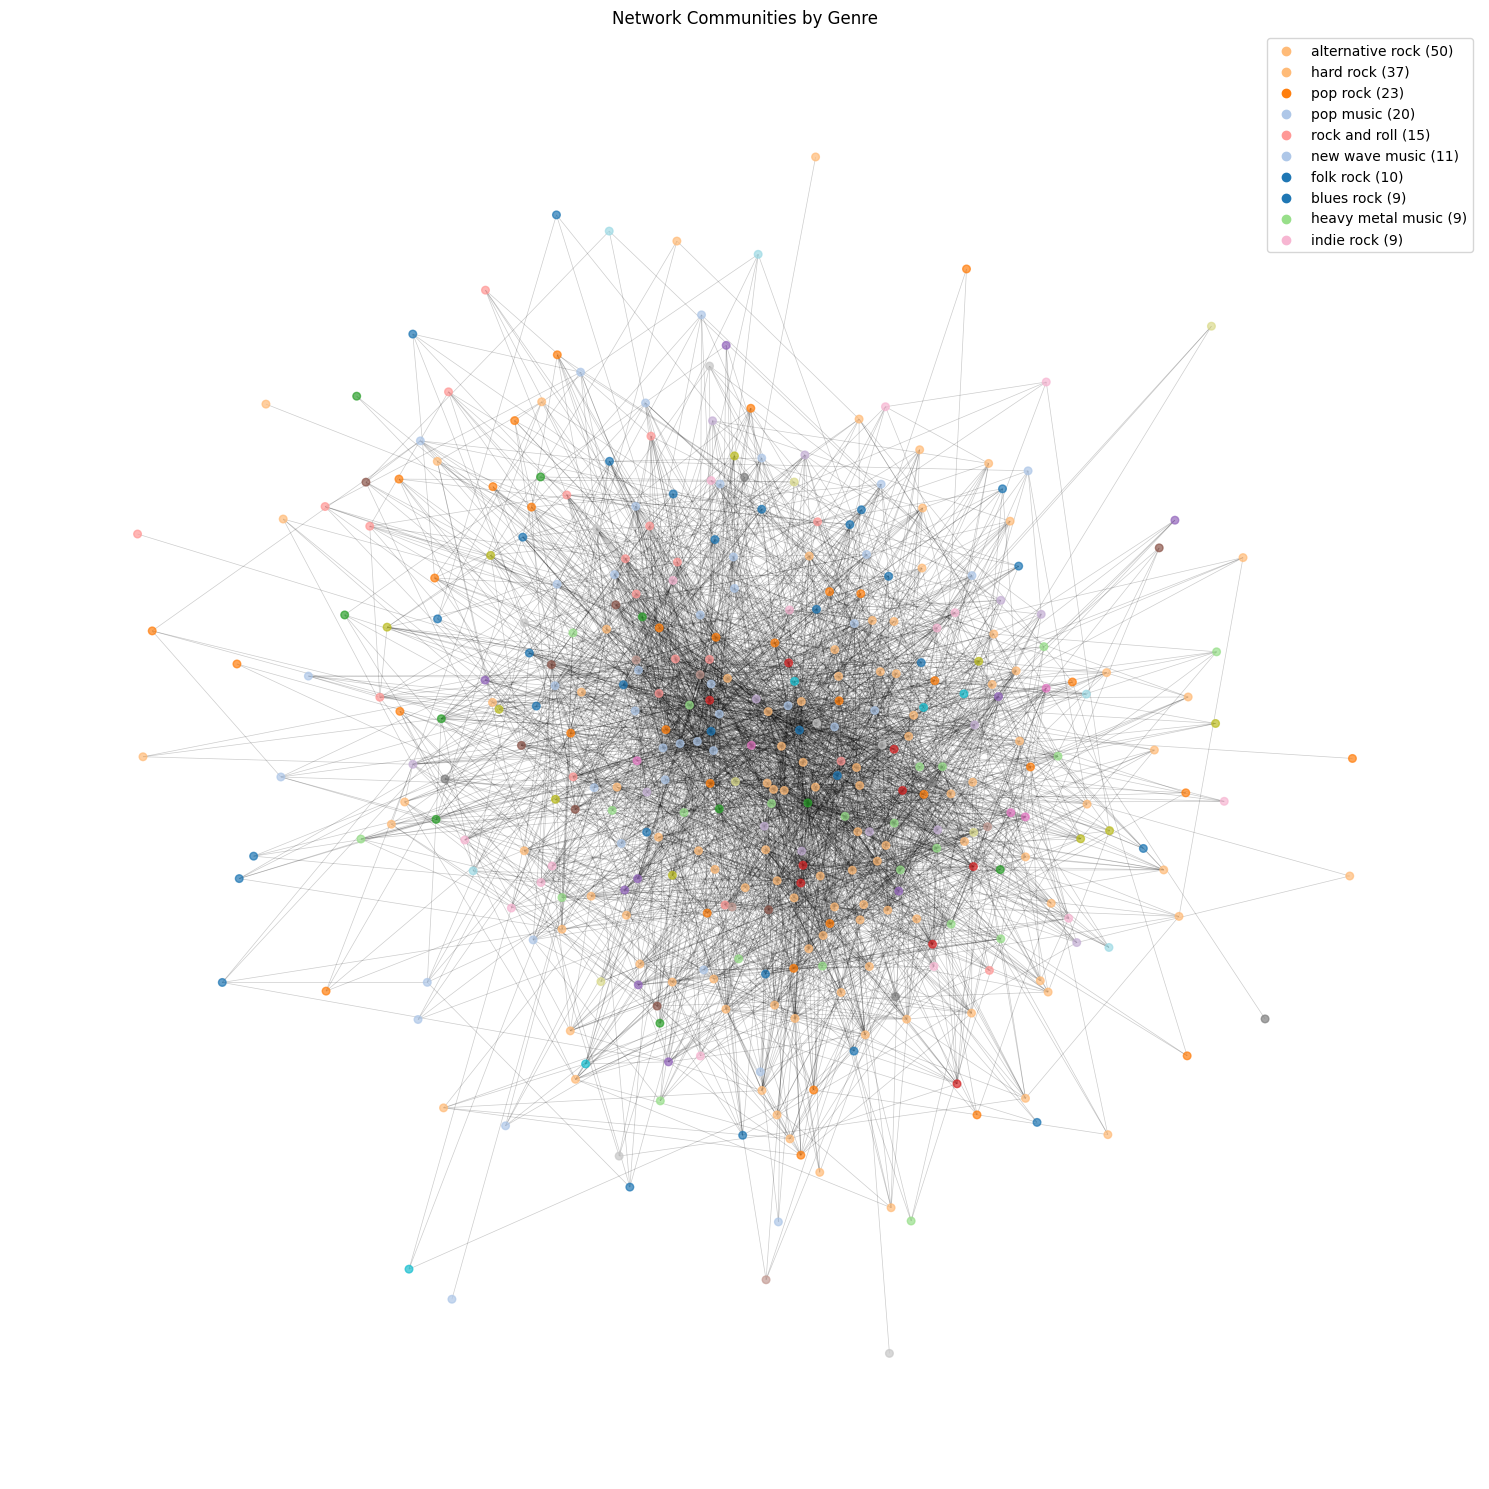

In [ ]:
"""
Plot network with nodes colored by genre community
"""
plt.figure(figsize=(15,15))

# Create color map for genres
genres = list(genre_to_nodes.keys())
colors = plt.cm.tab20(np.linspace(0, 1, len(genres)))
genre_to_color = dict(zip(genres, colors))

# Assign colors to nodes
node_colors = []
for node in G_filtered.nodes():
    node_genre = G_filtered.nodes[node].get('genre', 'unknown')
    if node_genre in genre_to_color:
        node_colors.append(genre_to_color[node_genre])
    else:
        node_colors.append('gray')

# Calculate layout
pos = nx.spring_layout(G_filtered, k=0.5, iterations=50)

# Draw network
nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, 
                        node_size=30, alpha=0.7)
nx.draw_networkx_edges(G_filtered, pos, alpha=0.2, width=0.5)

# Create legend for top genres
top_genres = sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:10]
for genre, nodes in top_genres:
    plt.scatter([], [], c=[genre_to_color[genre]], label=f'{genre} ({len(nodes)})')

plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.title("Network Communities by Genre")
plt.axis('off')
plt.tight_layout()
plt.show()

The plot more or less confirms what was suspected with the low modularity. 